# Intro to 4D-STEM data: strain

In this notebook we find the strain on a gold nanoplatelet sample.  

This data was simulated together with the gold nanoparticle dataset used in the basics 01-03 tutorial notebooks.  Here, we use the ellipticity and pixel size calibrations from notebook 03, then independently calibrate the origin and rotation for this dataset, before finally finding the strain.


### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)


Updated 11/1/2023, version 0.14.8

## Set up the environment

In [1]:
import py4DSTEM
from py4DSTEM.visualize import show
import matplotlib.pyplot as plt
py4DSTEM.__version__

'0.14.8'

---
# Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (501 megabytes)
* [Simulated single crystal and polycrystalline gold](https://drive.google.com/file/d/1m-jfXnStFWq0jo_hPY-3OtYaO62wHP3A/view?usp=drive_link)

# Load data

Load
- the same datacube as in the previous notebook, and 
- the results from basics_02 (disk detection)

In [2]:
# Set the filepaths

dirpath = "/Users/Ben/work/data/py4DSTEM_sampleData/calibration_simulatedAuNanoplatelet/"

filepath_data = dirpath + "sim_Au_data_all_binned.h5"
filepath_basics_01 = dirpath + 'analysis_basics_01.h5'
filepath_basics_02 = dirpath + 'analysis_basics_02.h5'
filepath_basics_03 = dirpath + 'analysis_basics_03.h5'

In [3]:
py4DSTEM.print_h5_tree( filepath_data )

/
|---4DSTEM_simulation
    |---4DSTEM_AuNanoplatelet
    |---4DSTEM_polyAu
    |---defocused_CBED
    |---vacuum_probe




In [4]:
# Load the nanoplatelet datacube

datacube = py4DSTEM.read(
    filepath = filepath_data,
    datapath = '4DSTEM_simulation/4DSTEM_AuNanoplatelet'
)

datacube

DataCube( A 4-dimensional array of shape (100, 84, 125, 125) called '4DSTEM_AuNanoplatelet',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [5]:
# Load the defocused CBED image

defocused_cbed = py4DSTEM.read(
    filepath = filepath_data,
    datapath = '4DSTEM_simulation/defocused_CBED'
)

defocused_cbed

DiffractionSlice( A 2-dimensional array of shape (512, 512) called 'defocused_CBED',
                  with dimensions:

                      dim0 = [0,1,2,...] pixels
                      dim1 = [0,1,2,...] pixels
)

In [6]:
# Load the prior analysis

basics_03 = py4DSTEM.read(
    filepath_basics_03
)

basics_03.tree()

Reading PointListArray: 100%|█████████| 8400/8400 [00:02<00:00, 3269.59PointList/s]

/
|---2Dhist_braggvectors_cal_s=8
|---braggvectors
|---probe


## Transfer calibrations

In [7]:
bvs_AuNPs = basics_03.tree('braggvectors')

bvs_AuNPs.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.02
             R_pixel_size:       1
             Q_pixel_units:      A^-1
             R_pixel_units:      pixels
             QR_flip:            False
             _root_treepath:     
             a:                  298.1941924997993
             b:                  278.2326703781001
             origin_meas_mask:   2D-array
             probe_semiangle:    5.14092564018049
             qx0:                2D-array
             qx0_mean:           63.47416802294156
             qx0_meas:           2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           63.22499601104463
             qy0_meas:           2D-array
             qy0_shift:          2D-array
             theta:              -2.1139796310061887
)

In [8]:
datacube.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         False
             _target_paths:   ['/4DSTEM_polyAu']
)

In [9]:
datacube.calibration.set_Q_pixel_size( bvs_AuNPs.calibration.get_Q_pixel_size() )
datacube.calibration.set_Q_pixel_units( bvs_AuNPs.calibration.get_Q_pixel_units() )
datacube.calibration.set_ellipse( bvs_AuNPs.calibration.get_ellipse() )

datacube.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.02
             R_pixel_size:    1
             Q_pixel_units:   A^-1
             R_pixel_units:   pixels
             QR_flip:         False
             _target_paths:   ['/4DSTEM_polyAu']
             a:               298.1941924997993
             b:               278.2326703781001
             theta:           -2.1139796310061887
)

# Basic visualizations

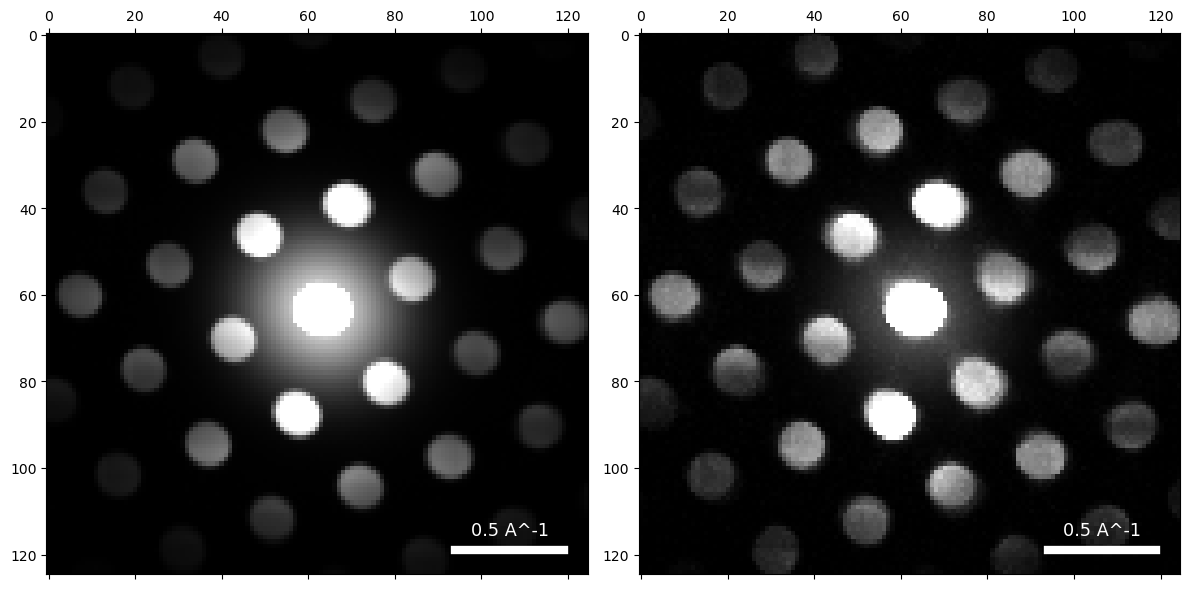

In [10]:
# mean + max diffraction

dp_mean = datacube.get_dp_mean()
dp_max = datacube.get_dp_max()

show(
    [dp_mean,dp_max]
)

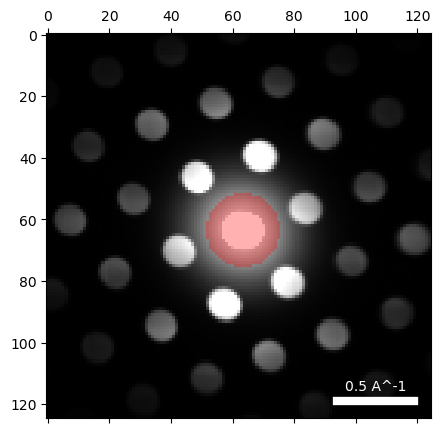

In [11]:
# virtual imaging - position detector

center = 63.5,63.5
radius = 12

datacube.position_detector(
    mode = 'circle',
    geometry = (center,radius)
)

100%|███████████████████████████████████████| 8400/8400 [00:00<00:00, 38248.59it/s]


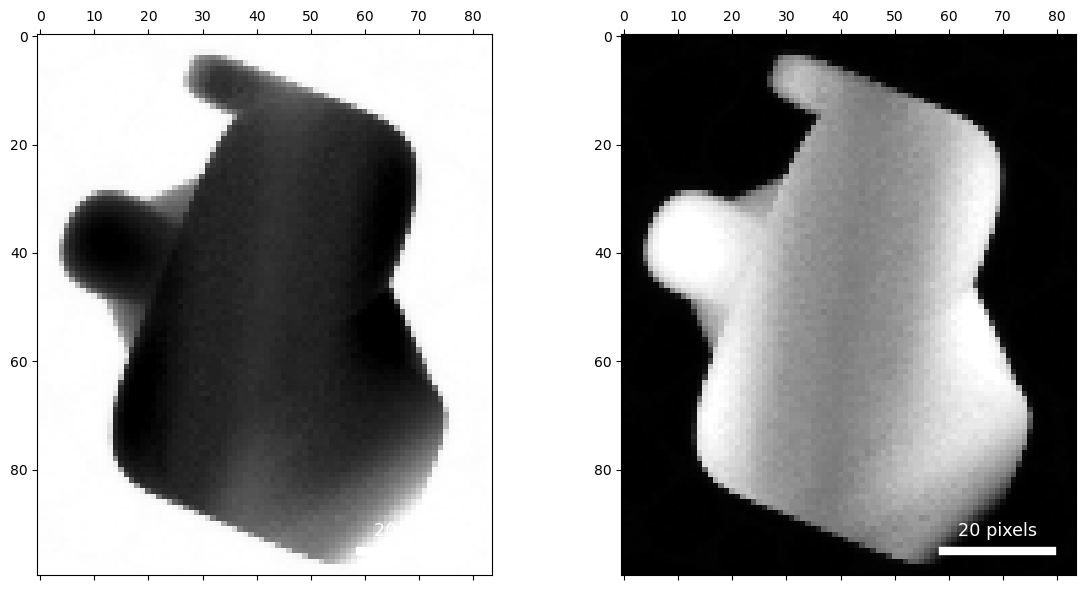

In [12]:
# virtual imaging - capture images

im_bf = datacube.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius)
)
im_adf = datacube.get_virtual_image(
    mode = 'annulus',
    geometry = (center,(radius,radius*10))
)

show(
    [im_bf,im_adf]
)

# Find Bragg vectors

In [13]:
probe = basics_03.tree('probe')

probe

Probe( A stack of 2 Arrays with 2-dimensions and shape (125, 125), called 'probe'

       The labels are:
           probe
           kernel


       The Array dimensions are:
           dim0 = [0,1,2,...] pixels
           dim1 = [0,1,2,...] pixels
)

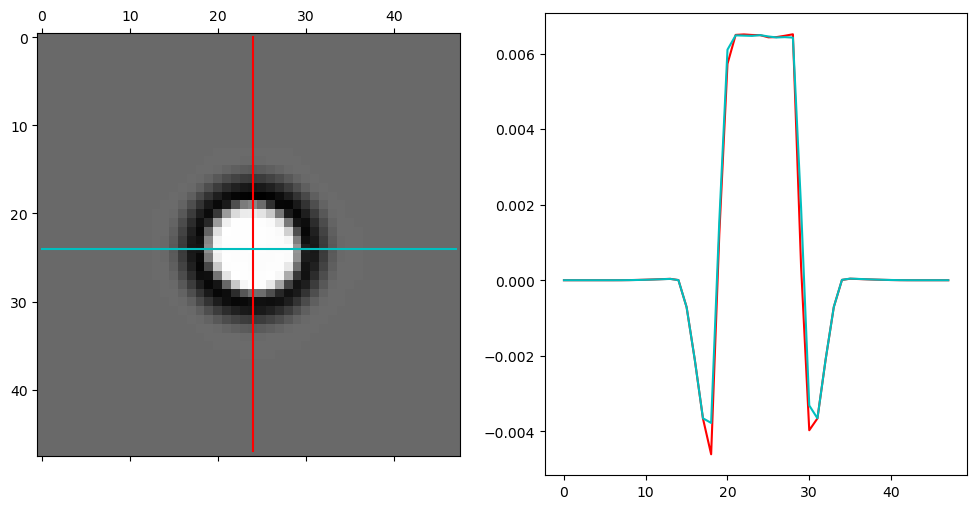

In [14]:
py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 24,
    L = 24,
    W = 1
)

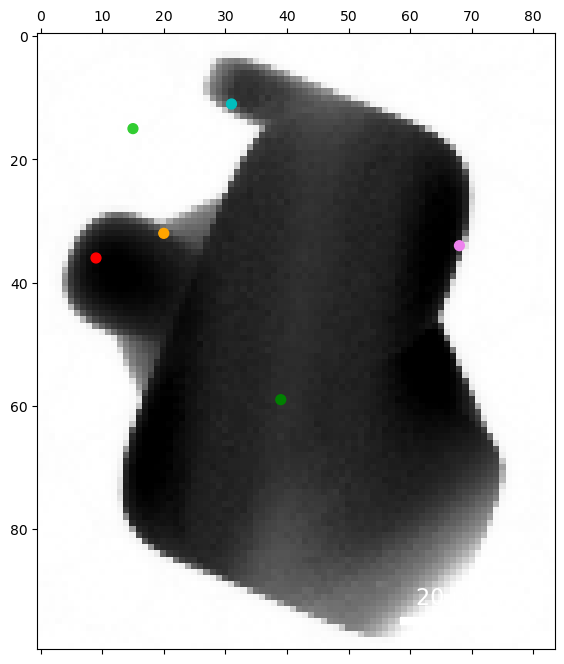

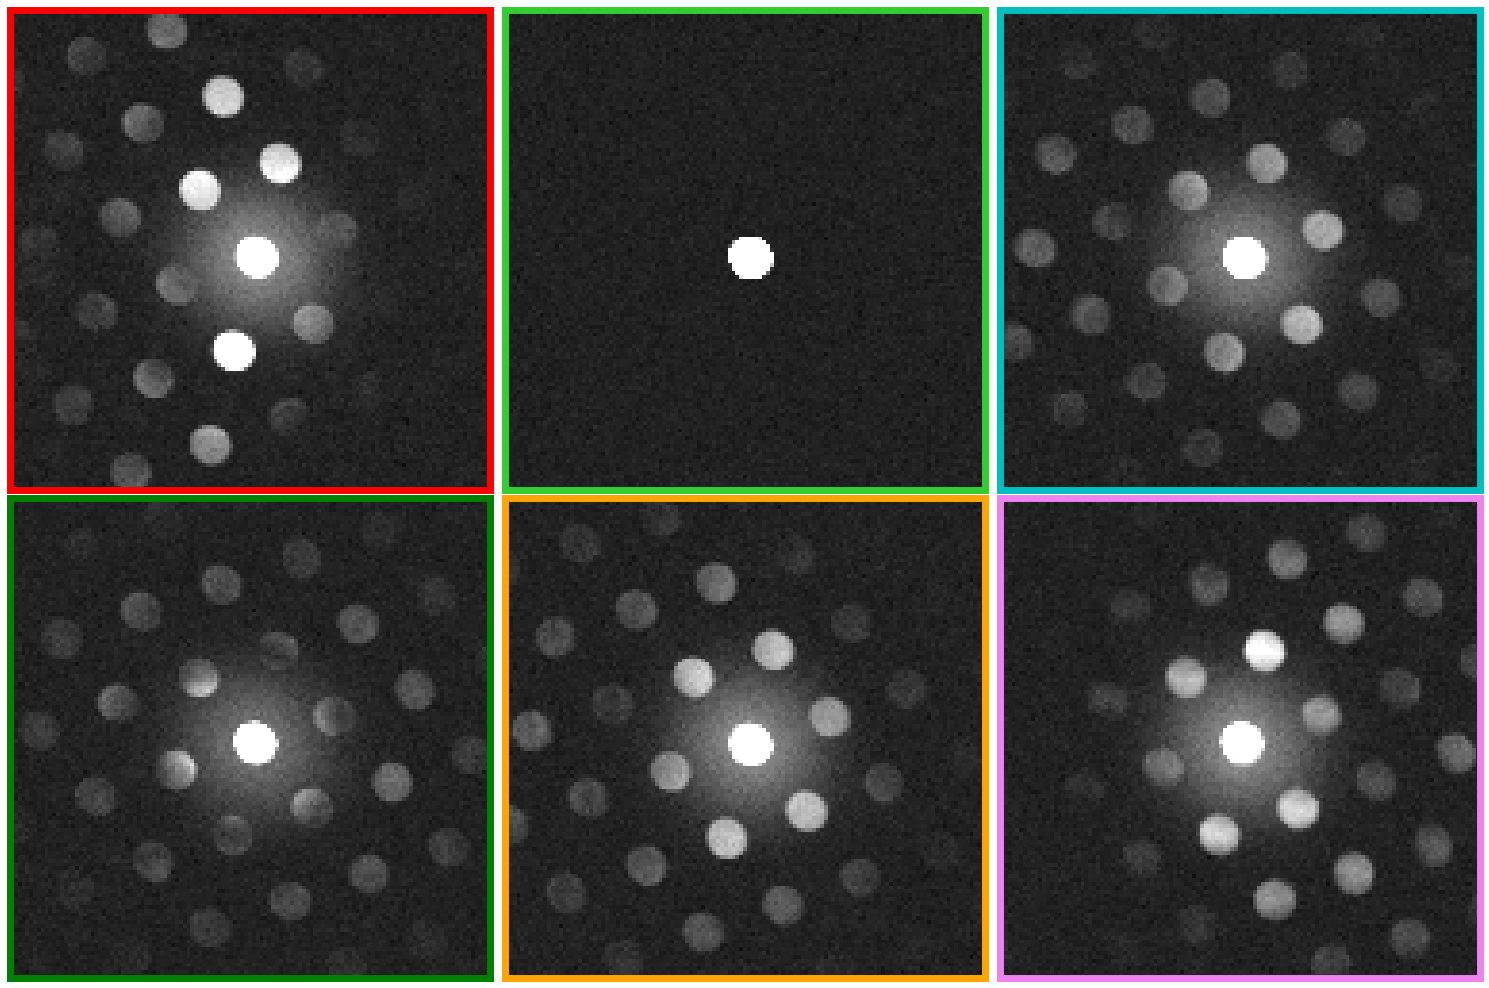

In [15]:
# Select a few sample patterns for parameter tuning


# choose scan positions

rxs = 36,15,11,59,32,34
rys = 9,15,31,39,20,68,



# visualize

colors=['r','limegreen','c','g','orange', 'violet']

# show the selected
# positions in real space
py4DSTEM.visualize.show_points(
    im_bf,
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# show the selected
# diffraction patterns
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2,W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
)

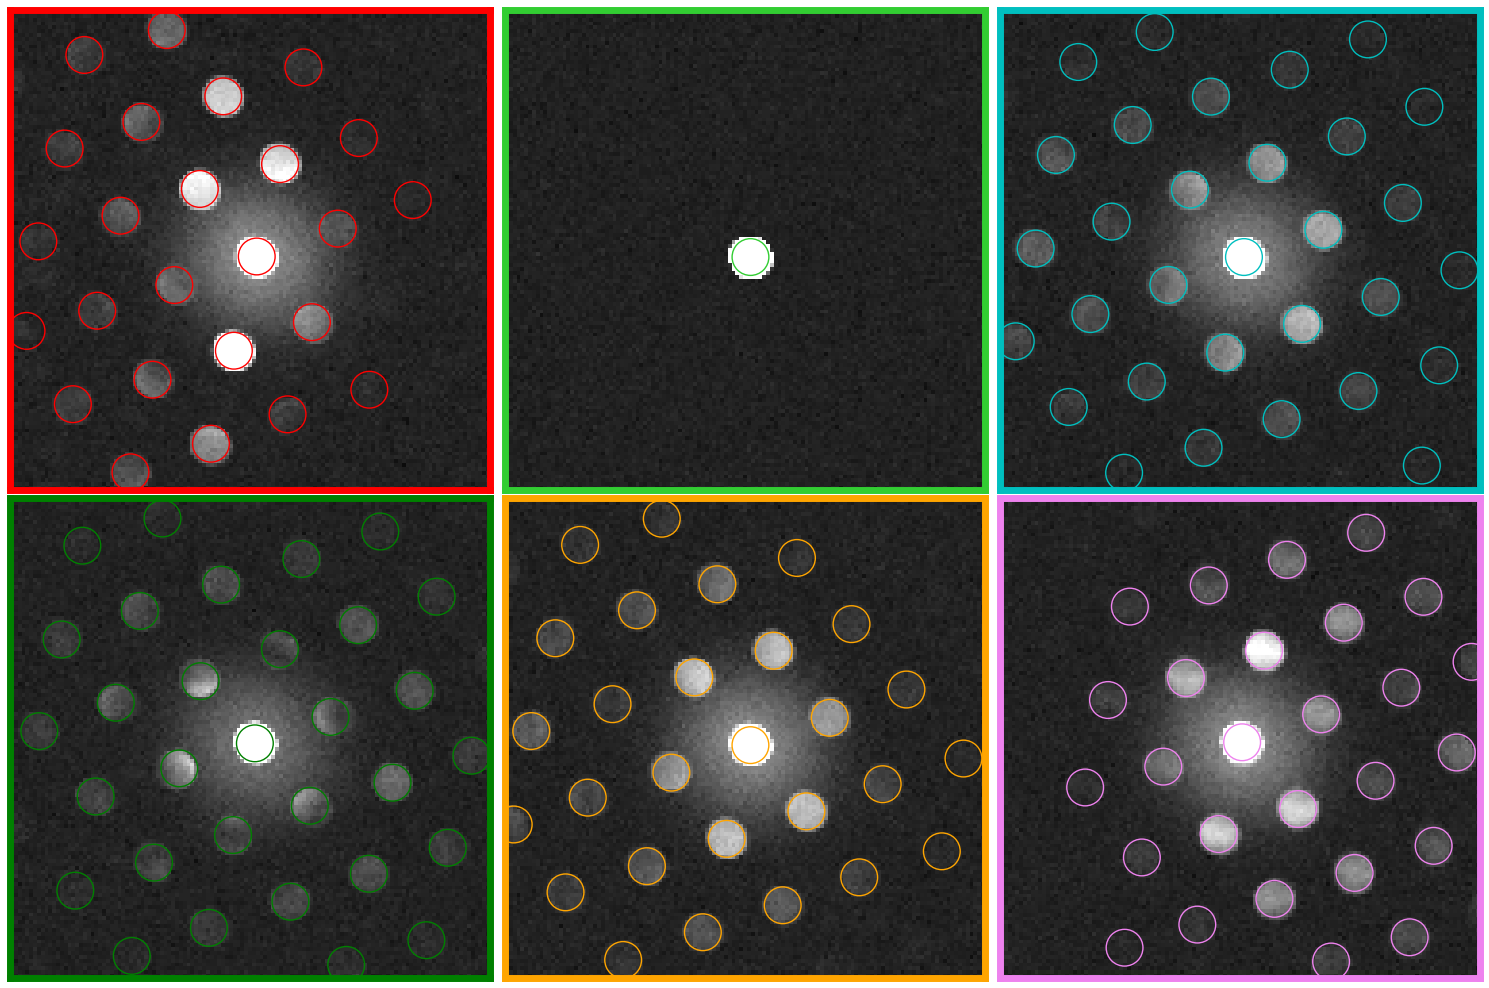

In [16]:
# Choose disk detection parameters


# set parameters

detect_params = {
    'minAbsoluteIntensity': 2,
    'minRelativeIntensity': 0,
    'minPeakSpacing': 18,
    'edgeBoundary': 2,
    'sigma': 0,
    'maxNumPeaks': 100,
    'subpixel' : 'poly',
    'corrPower': 1.0,
#     'CUDA': True,
}


# find disks for selected patterns
disks_selected = datacube.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

# show
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [17]:
# compute for all diffraction patterns

braggpeaks = datacube.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|█████████████████████| 8.40k/8.40k [00:16<00:00, 512DP/s]


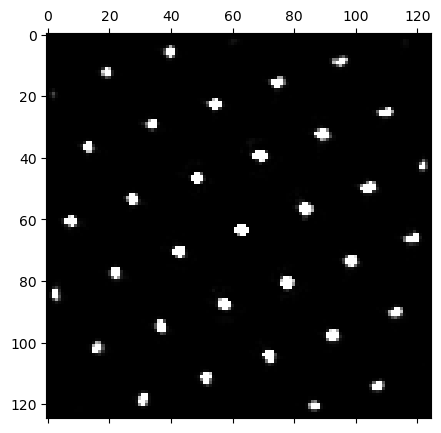

In [18]:
# Bragg vector map

# compute
bvm = braggpeaks.histogram( mode='raw' )

# show
show(bvm)

# Calibrate the origin

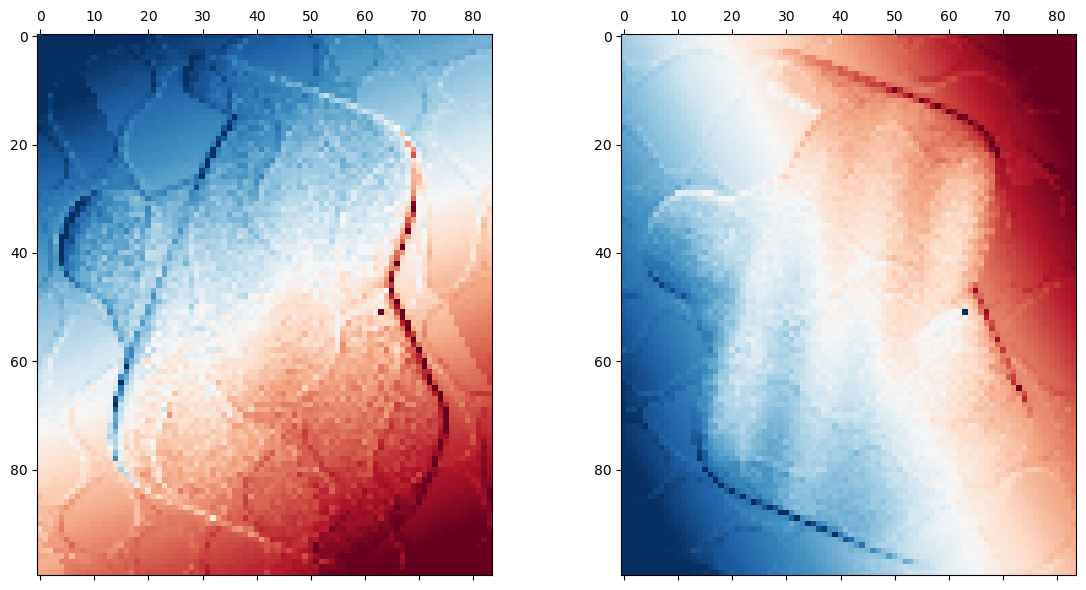

In [19]:
# Measure the origin

qx0_meas,qy0_meas,mask_meas = braggpeaks.measure_origin()

show(
    [qx0_meas,qy0_meas],
    cmap = 'RdBu',
    mask = mask_meas
)

In [20]:
# Note that braggpeaks.measure_origin added its results to the Calibration metadata

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.02
             R_pixel_size:       1
             Q_pixel_units:      A^-1
             R_pixel_units:      pixels
             QR_flip:            False
             _target_paths:      ['/4DSTEM_polyAu']
             a:                  298.1941924997993
             b:                  278.2326703781001
             theta:              -2.1139796310061887
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
)

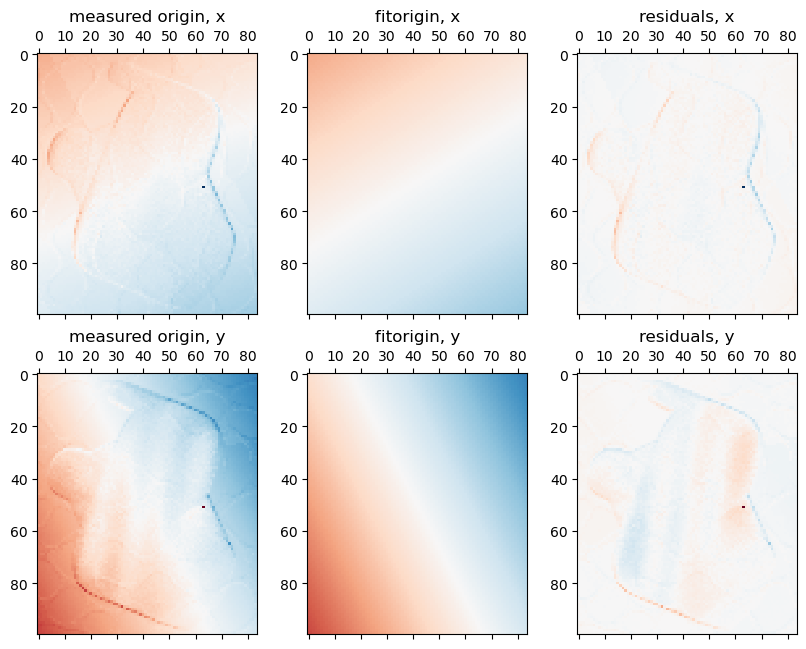

In [21]:
# Fit a plane to the origins

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = braggpeaks.fit_origin()

In [22]:
# The fit origins now live in the calibration metadata as 'qx0','qy0'

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.02
             R_pixel_size:       1
             Q_pixel_units:      A^-1
             R_pixel_units:      pixels
             QR_flip:            False
             _target_paths:      ['/4DSTEM_polyAu']
             a:                  298.1941924997993
             b:                  278.2326703781001
             theta:              -2.1139796310061887
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_mean:           63.47485920535144
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           63.22631643174276
             qy0_shift:          2D-array
)

In [23]:
# The calibration state of our BraggVectors has automatically updated

braggpeaks.calstate

{'center': True, 'ellipse': True, 'pixel': True, 'rotate': False}

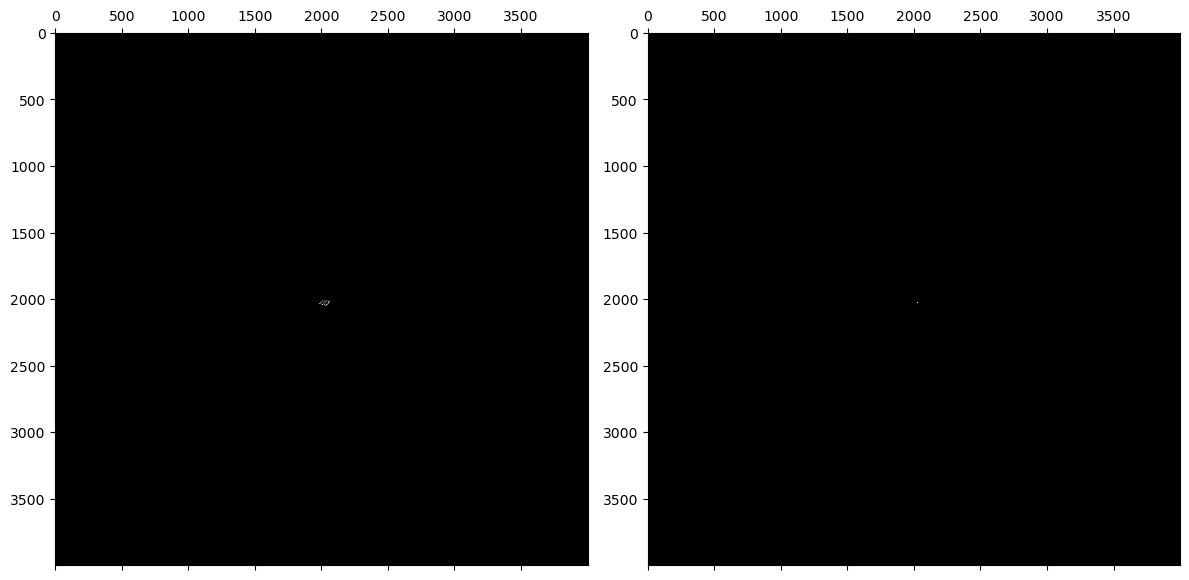

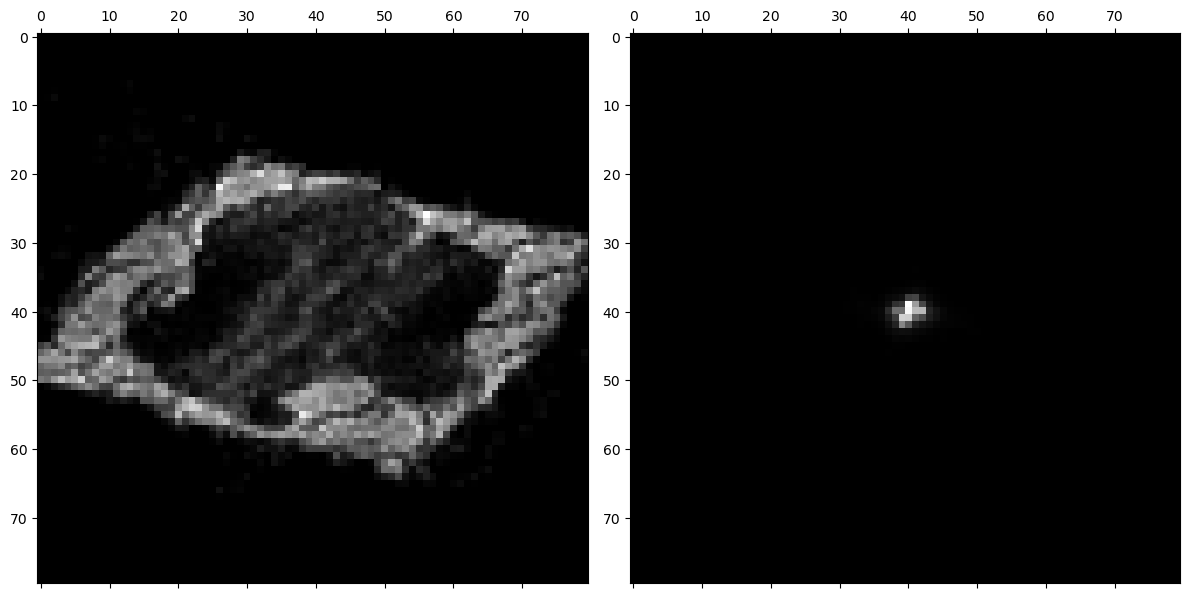

In [24]:
# Compare this to the uncalibrated BVM - much better!

# compute raw vs. centered
bvm_r = braggpeaks.histogram( mode='raw', sampling=32 )
bvm_c = braggpeaks.histogram( mode='cal', sampling=32 )

# show
show( [bvm_r, bvm_c] ,vmax=0.999999)

# show, zooming in on origin
L = 40
x,y = bvm_c.origin
import numpy as np
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
    vmax=0.999999
)

# Calibrate the rotation

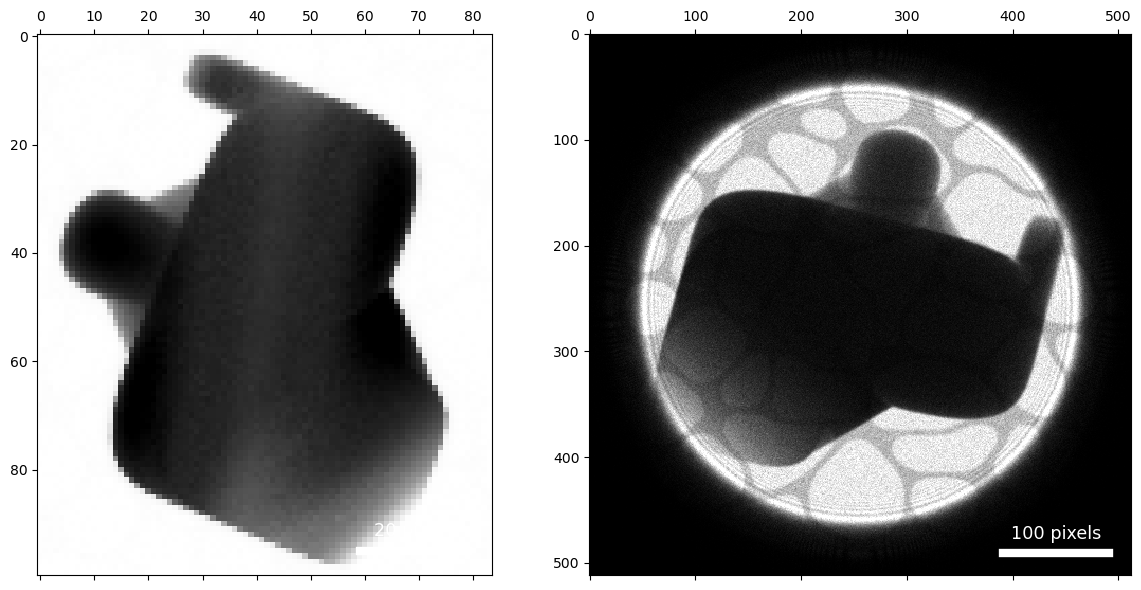

In [25]:
# Compare a virtual image to the defocused CBED image

show(
    [im_bf,defocused_cbed]
)

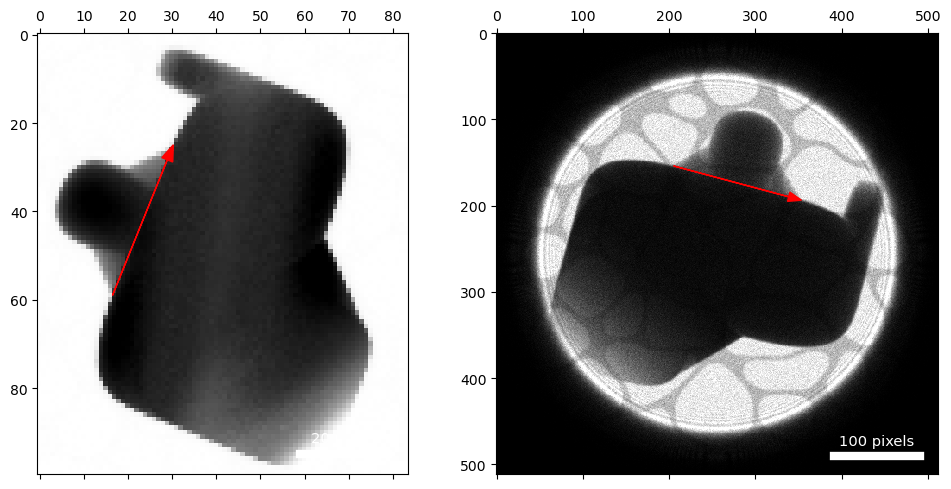

In [26]:
# Find the QR rotation

QR_rotation = -83   # in degrees

py4DSTEM.process.calibration.compare_QR_rotation(
    im_bf,
    defocused_cbed,
    QR_rotation,
    R_rotation = 158,
    R_position = (59,16.5),
    Q_position = (154,205),
    R_pos_anchor = 'tail',
    Q_pos_anchor = 'tail',
    R_length = 0.4,
    Q_length = 0.3,
    #figsize = (10,5),
)

In [27]:
# Set the rotation

braggpeaks.calibration.set_QR_rotation_degrees( QR_rotation )
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          0.02
             R_pixel_size:          1
             Q_pixel_units:         A^-1
             R_pixel_units:         pixels
             QR_flip:               False
             _target_paths:         ['/4DSTEM_polyAu']
             a:                     298.1941924997993
             b:                     278.2326703781001
             theta:                 -2.1139796310061887
             qx0_meas:              2D-array
             qy0_meas:              2D-array
             origin_meas_mask:      2D-array
             qx0:                   2D-array
             qx0_mean:              63.47485920535144
             qx0_shift:             2D-array
             qy0:                   2D-array
             qy0_mean:              63.22631643174276
             qy0_shift:             2D-array
             QR_rotation:           -1.4486232791552935
        

# Strain mapping

In [28]:
strainmap = py4DSTEM.StrainMap( braggvectors=braggpeaks )

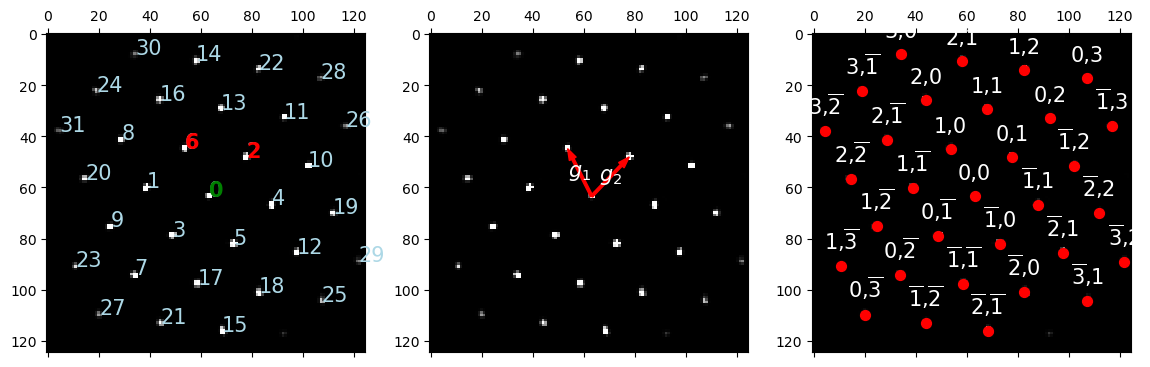

In [29]:
strainmap.choose_basis_vectors(
    minSpacing=4,
    minAbsoluteIntensity=3e3,
    maxNumPeaks=100,
    edgeBoundary=1,
    vis_params = {
        'vmin' : 0,
        'vmax' : 0.995
    }
)

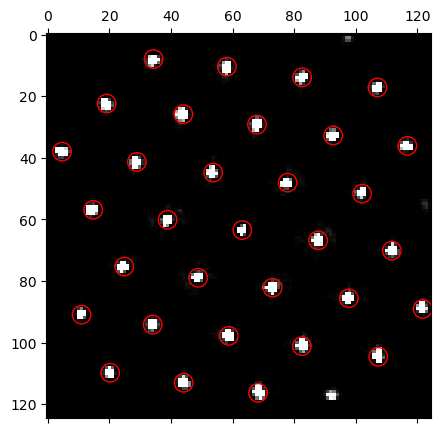

In [30]:
strainmap.set_max_peak_spacing(
    max_peak_spacing = 3
)

In [31]:
strainmap.fit_basis_vectors(
     # max_peak_spacing = 3
)

Indexing Bragg scattering: 100%|█████████████| 8.40k/8.40k [00:05<00:00, 1.56kDP/s]
Fitting lattice vectors: 100%|███████████████| 8.40k/8.40k [00:01<00:00, 4.85kDP/s]


Calculating strain: 100%|████████████████████| 8.40k/8.40k [00:02<00:00, 3.85kDP/s]


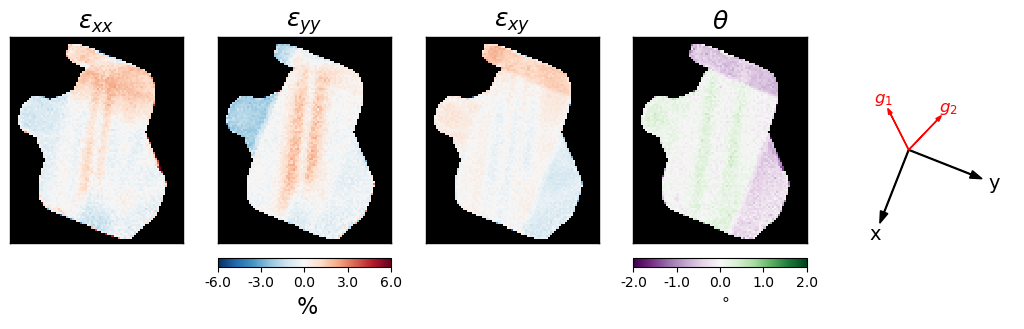

In [32]:
# strain map

strainmap.get_strain(
#    coordinate_rotation = 0,
    coordinate_rotation = -21.5,
    layout = 1,
    vrange = [-6.0, 6.0],
    vrange_theta = [-2.0, 2.0],
)

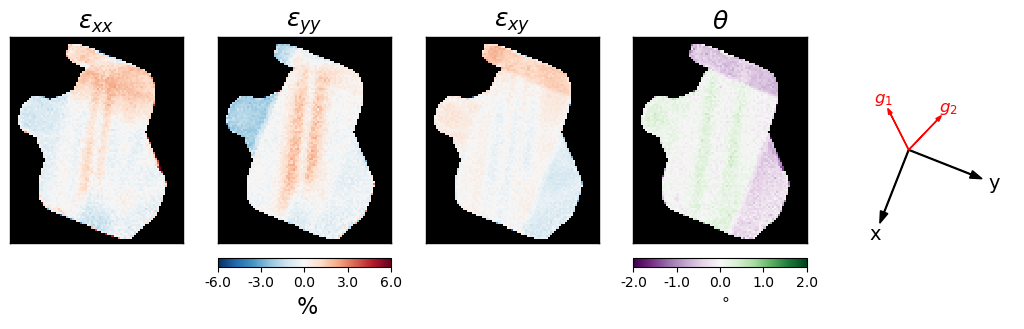

In [33]:
strainmap.show_strain(
    vrange = [-6,6],
    vrange_theta = [-2,2],
    layout = 1,
)

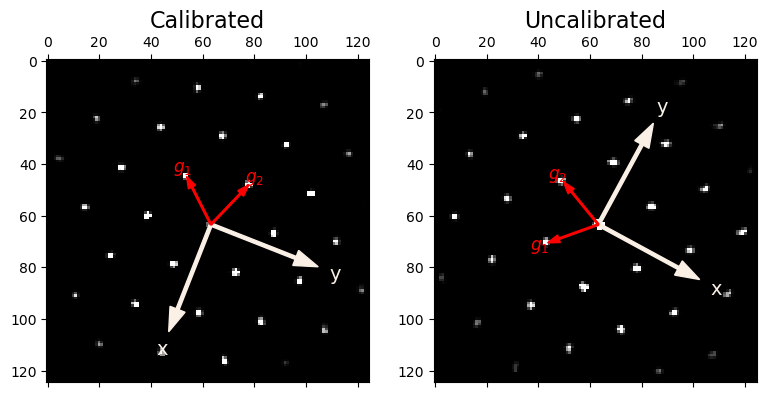

In [34]:
strainmap.show_reference_directions(
    visp_cal={
        'scaling' : 'none',
        'vmax' : 0.995
    },
    visp_uncal={
        'scaling' : 'none',
        'vmax' : 0.995
    },
    camera_length = 1.4,
)

# Strain using reference $g_1$ and $g_2$ from an ROI

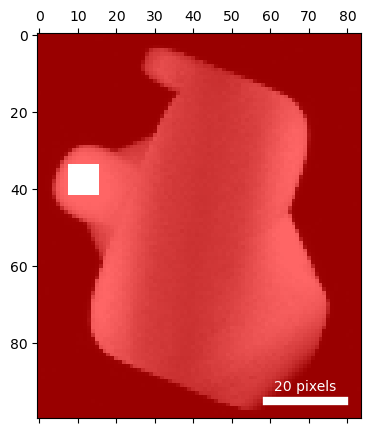

In [37]:
# Set reference region

ROI = np.zeros(braggpeaks.Rshape, dtype=bool)
ROI[34:42, 8:16] = True

show(
    im_adf,
    mask = ROI,
    mask_color='r',
    mask_alpha=0.4
)

Calculating strain: 100%|████████████████████| 8.40k/8.40k [00:02<00:00, 3.71kDP/s]


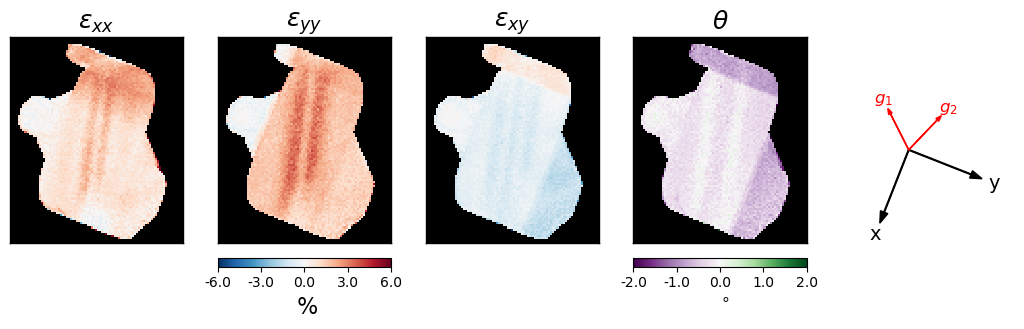

In [38]:
# strain from a region

strainmap.get_strain(
    gvects = ROI,
#    coordinate_rotation = 0,
    coordinate_rotation = -21.5,
    layout = 1,
    vrange = [-6.0, 6.0],
    vrange_theta = [-2.0, 2.0],
)

# Strain using a manually specified reference $g_1$ and $g_2$

Calculating strain: 100%|████████████████████| 8.40k/8.40k [00:02<00:00, 3.81kDP/s]


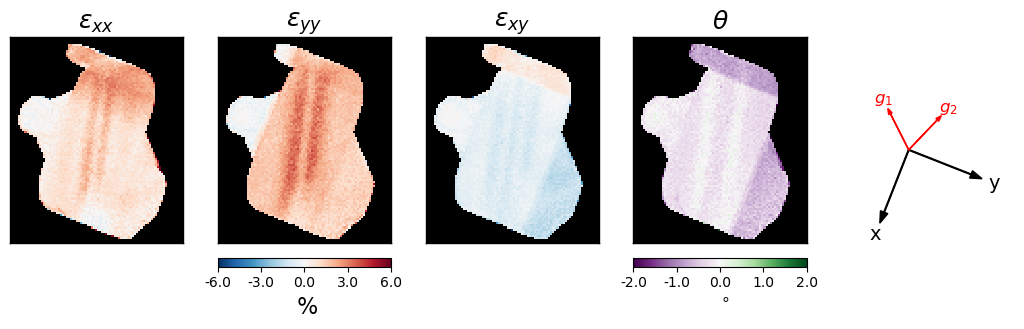

In [39]:
g1_ref, g2_ref = strainmap.get_reference_g1g2( ROI )

strainmap.get_strain(
    gvects = (g1_ref,g2_ref),
    coordinate_rotation = -21.5,
    layout = 1,
    vrange = [-6.0, 6.0],
    vrange_theta = [-2.0, 2.0],
)